In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, log_loss
from sklearn.inspection import DecisionBoundaryDisplay

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Task 1

### 1a) Loading Data

#### Train


In [4]:
train = pd.read_csv('train.csv')
x, y = train['Text'], train['Category']

# Encode the target variable
train_y = LabelEncoder().fit_transform(y)

# Vectorize the text
cv = CountVectorizer()
train_x = cv.fit_transform(x)
feature_names = cv.get_feature_names_out()
train_x = pd.DataFrame(train_x.toarray(), columns=feature_names)

#### Test


In [5]:
test = pd.read_csv('test.csv')
x, y = test['Text'], test['Category']

# Encode the target variable
test_y = LabelEncoder().fit_transform(y)

# Vectorize the text
cv = CountVectorizer(vocabulary=feature_names)
test_x = cv.fit_transform(x)
test_x = pd.DataFrame(test_x.toarray(), columns=feature_names)

#### Example Articles

In [23]:
print(f'Number of Articles: {train_x.shape[0]}')
print(f'Number of Features: {train_x.shape[1]}')   

example = train.join(train_x)
example.head()

Number of Articles: 428
Number of Features: 13518


ArticleId                                               Text  \
0       1976  lifestyle governs mobile choice faster better ...   
1       1797  french honour director parker british film dir...   
2       1866  fockers fuel festive film chart comedy meet fo...   
3       1153  housewives lift channel 4 ratings debut us tel...   
4        342  u2 desire number one u2 three prestigious gram...   

        Category  00  000  000th  001st  0051  007  0100  ...  zola  zombie  \
0           tech   0    1      0      0     0    0     0  ...     0       0   
1  entertainment   0    0      0      0     0    0     0  ...     0       0   
2  entertainment   0    0      0      0     0    0     0  ...     0       0   
3  entertainment   0    0      0      0     0    0     0  ...     0       0   
4  entertainment   0    0      0      0     0    0     0  ...     0       0   

   zombies  zone  zonealarm  zones  zoom  zooms  zooropa  zorro  
0        0     0          0      0     0      0        0      0  
1        0     0          0      0     0      0        0      0  
2        0     0          0      0     0      0        0      0  
3        0     0          0      0     0      0        0      0  
4        0     0          0      0     0      0        1      0  

[5 rows x 13521 columns]

### 1b)i) Top-50 Term Frequency Distribution

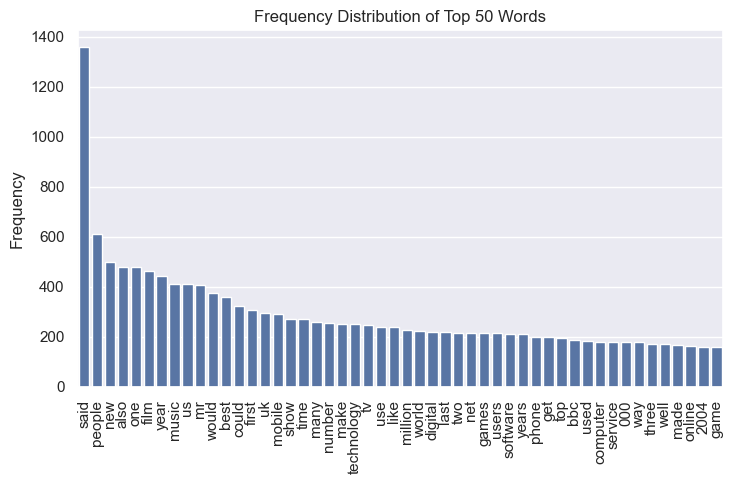

In [45]:
word_totals = train_x.sum(axis=0)
top_50 = word_totals.sort_values(ascending=False).head(50)

sns.set_theme(rc={'figure.figsize':(7.5,5)})
sns.barplot(top_50)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Top 50 Words')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot shows the top 50 most frequent words in the training dataset.

### 1b)ii) Term Frequency Distribution by Class

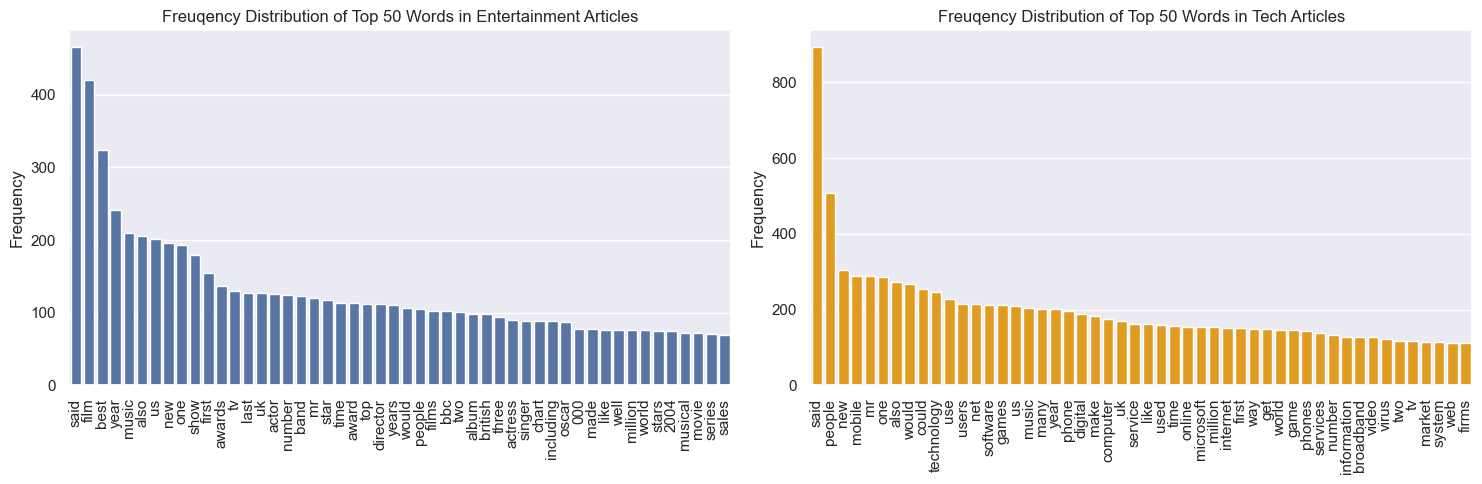

In [50]:
totals_by_class = train_x.groupby(train_y)

entertainment, tech = [df.sum(numeric_only=True) for _, df in totals_by_class]
entertainment.sort_values(ascending=False, inplace=True)
tech.sort_values(ascending=False, inplace=True)

sns.set_theme(rc={'figure.figsize':(15,5)})

plt.subplot(1, 2, 1)
sns.barplot(entertainment.head(50))
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Entertainment Articles')

plt.subplot(1, 2, 2)
sns.barplot(tech.head(50), color='orange')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Tech Articles')

plt.tight_layout()

The above chart shows the top 50 most frequent words in entertainment articles on the left and the top 50 most frequent words in tech articles on the right.

### 1b)iii) Class Distribution

Text(0.5, 1.0, 'Class Distribution')

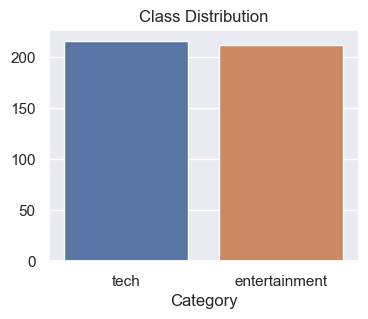

In [51]:
class_counts = train['Category'].value_counts()

sns.set_theme(rc={'figure.figsize':(4,3)})
sns.barplot(x = class_counts.index, y = class_counts.values, hue=class_counts.index)
plt.title('Class Distribution')

The above plot shows the distribution of classes within the training data. The distribution is basically equal.

# Task 2

### 2a) Naive Bayes

In [12]:
nb = MultinomialNB()
nb.fit(train_x, train_y)

print("Most likely tech words")
print(nb.feature_names_in_[np.argsort(nb.feature_log_prob_[1,:])[-20:]])
print("\nMost likely entertainment words")
print(nb.feature_names_in_[np.argsort(nb.feature_log_prob_[0,:])[-20:]])

def tech_ratio(x):
    return np.divide(x[0,:],x[1,:])

print("\nBest ratio tech words")
print(nb.feature_names_in_[np.argsort(tech_ratio(nb.feature_log_prob_))[-20:][::-1]])
print("\nBest ratio entertainment words")
print(nb.feature_names_in_[np.argsort(tech_ratio(nb.feature_log_prob_))[:20]])


Most likely tech words
['phone' 'year' 'many' 'music' 'us' 'games' 'software' 'net' 'users' 'use'
 'technology' 'could' 'would' 'also' 'one' 'mr' 'mobile' 'new' 'people'
 'said']

Most likely entertainment words
['star' 'mr' 'band' 'number' 'actor' 'uk' 'last' 'tv' 'awards' 'first'
 'show' 'one' 'new' 'us' 'also' 'music' 'year' 'best' 'film' 'said']

Best ratio tech words
['users' 'software' 'mobile' 'microsoft' 'broadband' 'virus' 'firms' 'net'
 'pc' 'technology' 'phones' 'spam' 'games' 'gadget' 'phone' 'consumer'
 'mobiles' 'gadgets' 'windows' 'machines']

Best ratio entertainment words
['actress' 'singer' 'oscar' 'band' 'stars' 'album' 'aviator' 'chart'
 'nominated' 'actor' 'festival' 'rock' 'nominations' 'charles' 'foxx'
 'oscars' 'starring' 'comedy' 'singles' 'film']


### 2b) K-Nearest Neighbours

Text(0.5, 1.0, '1-NN Surface Plot')

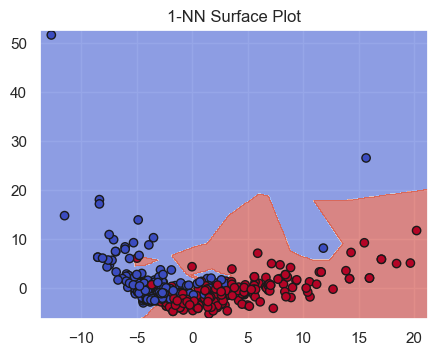

In [97]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(train_x)

knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2)
knn.fit(x_train_pca, train_y)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(knn, x_train_pca, grid_resolution=400, plot_method='contourf',
    response_method='predict', cmap = 'coolwarm', alpha = 0.6)
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=train_y, cmap='coolwarm', edgecolor="k")
plt.title("1-NN Surface Plot")

### 2c) Support Vector Machine

### 2c)i) Soft Margin SVM

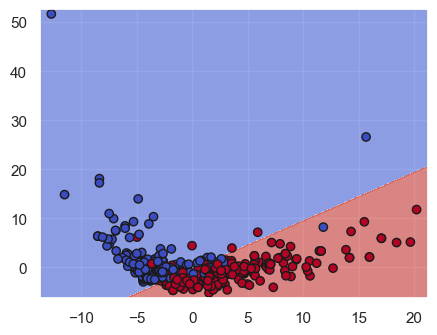

In [58]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(train_x)
svm = SVC(kernel='linear', C=1.0)
svm.fit(x_train_pca, train_y)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(svm, x_train_pca, grid_resolution=400, 
    plot_method='contourf', response_method='predict', cmap = 'coolwarm', alpha = 0.6)
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=train_y, cmap='coolwarm', edgecolor="k")

### 2c)ii) Hard Margin RBF Kernel SVM

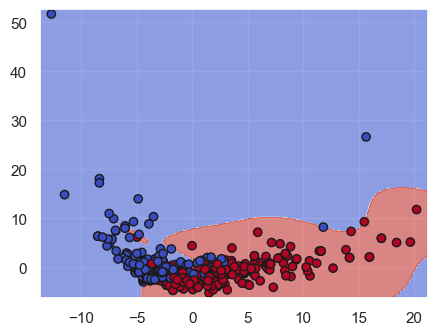

In [15]:

pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(train_x)

hm_svm = SVC(kernel='rbf', C=10**10, gamma='scale')
hm_svm.fit(x_train_pca, train_y)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(hm_svm, x_train_pca, 
    grid_resolution=400, plot_method='contourf', response_method='predict', cmap = 'coolwarm', alpha = 0.6)
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=train_y, cmap='coolwarm', edgecolor="k")

### 2d) Neural Network

Text(0.5, 1.0, 'Cross entropy loss versus number of hidden units for a NN')

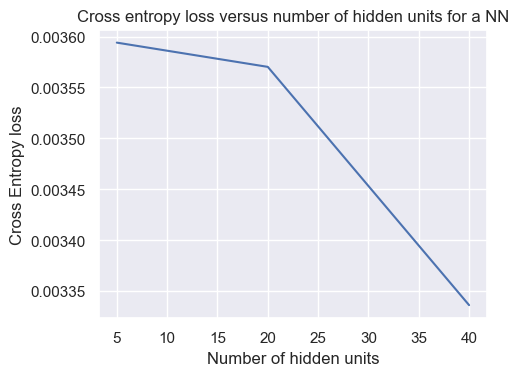

In [24]:
import random
random.seed(69)

hidden_units_list = [5, 20, 40]
cross_entropy_losses = [0]*len(hidden_units_list)
nn = MLPClassifier(
    random_state=420,
    solver = 'sgd',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=100
)
for i, hidden_units in enumerate(hidden_units_list):
    nn.set_params(hidden_layer_sizes = hidden_units)
    # Set up a dummy fit to change the weights
    nn.fit([[0]], [1])
    # Create our initial weights:
    nn.coefs_ = [np.array([random.uniform(0,0.1) for _ in range(hidden_units)]) for k in range(2)]
    nn.intercepts_ = [random.uniform(0,0.1) for _ in range(2)]

    nn.fit(train_x, train_y)
    cross_entropy_losses[i] = log_loss(train_y, nn.predict_proba(train_x), normalize=True)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
plt.plot(hidden_units_list, cross_entropy_losses)
plt.xlabel("Number of hidden units")
plt.ylabel("Cross Entropy loss")
plt.title("Cross entropy loss versus number of hidden units for a NN")

# Task 3

### 3a)

In [26]:
# part a
def plot_f1score_against_train_size(model, m_array = [0.1, 0.3, 0.5, 0.7, 0.9]):
    x_train_size = train_x.shape[0]
    train_accuracy, test_accuracy = [0]*len(m_array), [0]*len(m_array)
    for i, m in enumerate(m_array):
        iter_size = round(m*x_train_size)
        model.fit(train_x.head(iter_size), train_y[:iter_size])
        train_accuracy[i] = f1_score(train_y[:iter_size], model.predict(train_x.head(iter_size)))
        test_accuracy[i] = f1_score(test_y, model.predict(test_x))
    plt.plot(m_array, train_accuracy)
    plt.plot(m_array, test_accuracy)
    plt.legend(['Train', 'Test'])
    

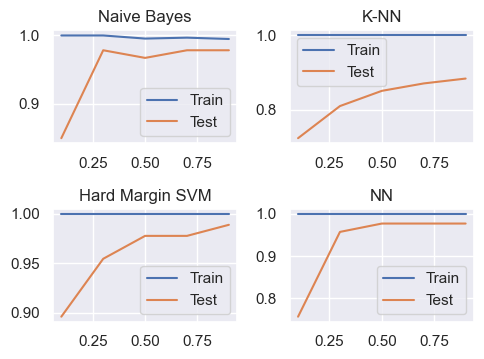

In [35]:
plt.subplot(2,2,1)
plot_f1score_against_train_size(MultinomialNB())
plt.title("Naive Bayes")
plt.subplot(2,2,2)
plot_f1score_against_train_size(KNeighborsClassifier(n_neighbors=1, metric='chebyshev', p=2))
plt.title("K-NN")
plt.subplot(2,2,3)
plot_f1score_against_train_size(SVC(kernel='rbf', C=10**10, gamma='scale'))
plt.title("Hard Margin SVM")
plt.subplot(2,2,4)
plot_f1score_against_train_size(MLPClassifier(learning_rate='constant', learning_rate_init=0.01, max_iter=100, random_state=420))
plt.title("NN")
plt.tight_layout()

### 3b)

In [50]:
# Task 3 b)
'''
Hyperparameters for each model
Naive Bayes: alpha
kNN: distance metric, neighbours
SVM: gamma for rbf, kernel
NN: depth, iterations, step_size
'''
from sklearn.model_selection import cross_validate
def five_fold(model, name):
    result = cross_validate(model, train_x, train_y, cv=5, scoring=['f1'])
    test_acc = sum(result['test_f1'])/5
    print(f"Test F1 Score of {name} : {test_acc}")

In [37]:
five_fold(MultinomialNB(alpha = 0.01), 'Naive Bayes with alpha 0.01')
five_fold(MultinomialNB(alpha = 0.5), 'Naive Bayes with alpha 0.5')
five_fold(MultinomialNB(alpha = 1), 'Naive Bayes with alpha 1')
five_fold(MultinomialNB(alpha = 4), 'Naive Bayes with alpha 4')

Test F1 Score of Naive Bayes with alpha 0.01 : 0.9861534349104518
Test F1 Score of Naive Bayes with alpha 0.5 : 0.9835261771107803
Test F1 Score of Naive Bayes with alpha 1 : 0.9812852807522369
Test F1 Score of Naive Bayes with alpha 4 : 0.9751775797494512


In [39]:
five_fold(KNeighborsClassifier(n_neighbors=1, metric='euclidean'), 'kNN with 1 neighbours, euclidean distance')
five_fold(KNeighborsClassifier(n_neighbors=1, metric='manhattan'), 'kNN with 1 neighbours, manhattan distance')
five_fold(KNeighborsClassifier(n_neighbors=3, metric='euclidean'), 'kNN with 3 neighbours, euclidean distance')
five_fold(KNeighborsClassifier(n_neighbors=5, metric='euclidean'), 'kNN with 5 neighbours, euclidean distance')
five_fold(KNeighborsClassifier(n_neighbors=10, metric='euclidean'), 'kNN with 10 neighbours, euclidean distance')

Test F1 Score of kNN with 1 neighbours, euclidean distance : 0.8029596920864528
Test F1 Score of kNN with 1 neighbours, manhattan distance : 0.7214955471164284
Test F1 Score of kNN with 3 neighbours, euclidean distance : 0.6464235384165147
Test F1 Score of kNN with 5 neighbours, euclidean distance : 0.613483938106106
Test F1 Score of kNN with 10 neighbours, euclidean distance : 0.2938430897765247


In [42]:
five_fold(SVC(kernel='linear', C=0.001), 'Soft-margin linear SVM with penalty 0.001')
five_fold(SVC(kernel='linear', C=1.0), 'Soft-margin linear SVM with penalty 1.0')
five_fold(SVC(kernel='linear', C=10), 'Soft-margin linear SVM with penalty 10')
five_fold(SVC(kernel='linear', C=1000), 'Soft-margin linear SVM with penalty 1000')

Test F1 Score of Soft-margin linear SVM with penalty 0.001 : 0.9564238937379379
Test F1 Score of Soft-margin linear SVM with penalty 1.0 : 0.964365070208526
Test F1 Score of Soft-margin linear SVM with penalty 10 : 0.964365070208526
Test F1 Score of Soft-margin linear SVM with penalty 1000 : 0.964365070208526


In [46]:
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 'scale'), 'Hard-margin RBF SVM with scaled gamma')
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 'auto'), 'Hard-margin RBF SVM with auto gamma')
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 0.01), 'Hard-margin RBF SVM with gamma 0.01')
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 0.0001), 'Hard-margin RBF SVM with gamma 0.0001')
five_fold(SVC(kernel='sigmoid', C = float(10**10), gamma = 'scale'), 'Hard-margin sigmoid SVM with scaled gamma')
five_fold(SVC(kernel='sigmoid', C = float(10**10), gamma = 'auto'), 'Hard-margin sigmoid SVM with auto gamma')

Test F1 Score of Hard-margin RBF SVM with scaled gamma : 0.9613203167101936
Test F1 Score of Hard-margin RBF SVM with auto gamma : 0.9693544394501987
Test F1 Score of Hard-margin RBF SVM with gamma 0.01 : 0.8321341324421851
Test F1 Score of Hard-margin RBF SVM with gamma 0.0001 : 0.9717067516661837
Test F1 Score of Hard-margin RBF SVM with scaled gamma : 0.8776766401253406
Test F1 Score of Hard-margin RBF SVM with auto gamma : 0.964365070208526


In [49]:
five_fold(MLPClassifier(alpha = 100, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 100')
five_fold(MLPClassifier(alpha = 10, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 10')
five_fold(MLPClassifier(alpha = 1, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 1')
five_fold(MLPClassifier(alpha = 0.01, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 0.01')
five_fold(MLPClassifier(alpha = 0.0001, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 0.0001')

Test F1 Score of NN with alpha = 100 : 0.9466686402616018
Test F1 Score of NN with alpha = 10 : 0.979090248535553
Test F1 Score of NN with alpha = 1 : 0.9789870591380098
Test F1 Score of NN with alpha = 0.01 : 0.9249723810338606
Test F1 Score of NN with alpha = 0.0001 : 0.9275583346042398


### 3c)

In [ ]:
'''
Task 3 part c
Chosen Hyperparameters:
Naive Bayes: alpha = 0.01
kNN: 1 neighbour, Euclidean distance
Soft margin SVM: C = 1
Hard Margin SVM: rbf kernel, gamma = 0.0001
Neural Network: alpha = 10
'''
def test_accuracy(model):
    model.fit(train_x, train_y)
    return f1_score(test_y, model.predict(test_x))
# Print all selected models along with their performance on the test set
print('Naive Bayes:')
print(test_accuracy(MultinomialNB(alpha=0.01)))
print('kNN:')
print(test_accuracy(KNeighborsClassifier(n_neighbors=1, metric='euclidean')))
print('Soft Margin SVM:')
print(test_accuracy(SVC(kernel='linear', C = 1.0)))
print('Hard Margin Kernelized SVM:')
print(test_accuracy(SVC(kernel='rbf', C = 10**10, gamma = 0.0001)))
print('Neural Network:')
print(test_accuracy(MLPClassifier(alpha = 10, learning_rate_init = 0.01, learning_rate='constant', max_iter = 100, random_state = 39),'NN with alpha = 10'))


Naive Bayes:
0.9782608695652174
kNN:
0.875
Soft Margin SVM:
1.0
Hard Margin Kernelized SVM:
1.0
Neural Network:
1.0
